<a href="http://isa.uniovi.es/GSDPI"><img width=80% src="http://isa.uniovi.es//~idiaz/logos/header_gsdpi_somuniovi.png" alt=""></a>

____________________

# Rotating Machine Example
Ejemplo de visualización de un proceso industrial mediante *self-organizing maps* (SOM). Se utiliza un SOM para aproximar mediante una retícula 2D la geometría de los datos en un espacio de características (descriptores) de 5D. Proyectando los datos sobre la retícula se obtienen *mapas* empleando *planos de componentes* que describen el comportamiento del proceso en distintos aspectos.

1. Import libraries
2. Input dataset
3. Create and  initialize a SOM model
4. Train the SOM model
5. SOM component planes
6. SOM distance matrix
7. 3D SOM
8. SOM residual-based anomaly detection

### 1. Import libraries

In [1]:
import numpy as np
from somuniovi import *
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import requests
import json
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

### 2. Input dataset

#### Cargamos los datos

In [2]:
datos = json.loads(requests.get('http://isa.uniovi.es/~idiaz/datos/dataicann.json').text)

fm = datos['fm']
tm = 1/fm

# Definimos una lista con las etiquetas para cada ensayo
# Significado de las siglas:
# M = fallo mecánico, E = fallo eléctrico, N = normal, var = variable

class_labels = ['M','EM','N','E10','E15','E20','E5','Evar1','Evar2']

#### Extracción de características de motor 
Hacemos una extracción de características, tomando datos de 25, 100 Hz de las aceleraciones $a_x, a_y$ y de 50 Hz de la corriente $i_r$. *Nota: las vibraciones de 25 Hz muestran excentricidades (el motor gira a 25 Hz) y las vibraciones de 100 Hz están relacionadas con el fallo eléctrico (magnetostricción).*

$$
a^{25Hz}_{x}, a^{100Hz}_{x}, a^{25Hz}_{y}, a^{100Hz}_{y}, i^{50Hz}_{r}
$$

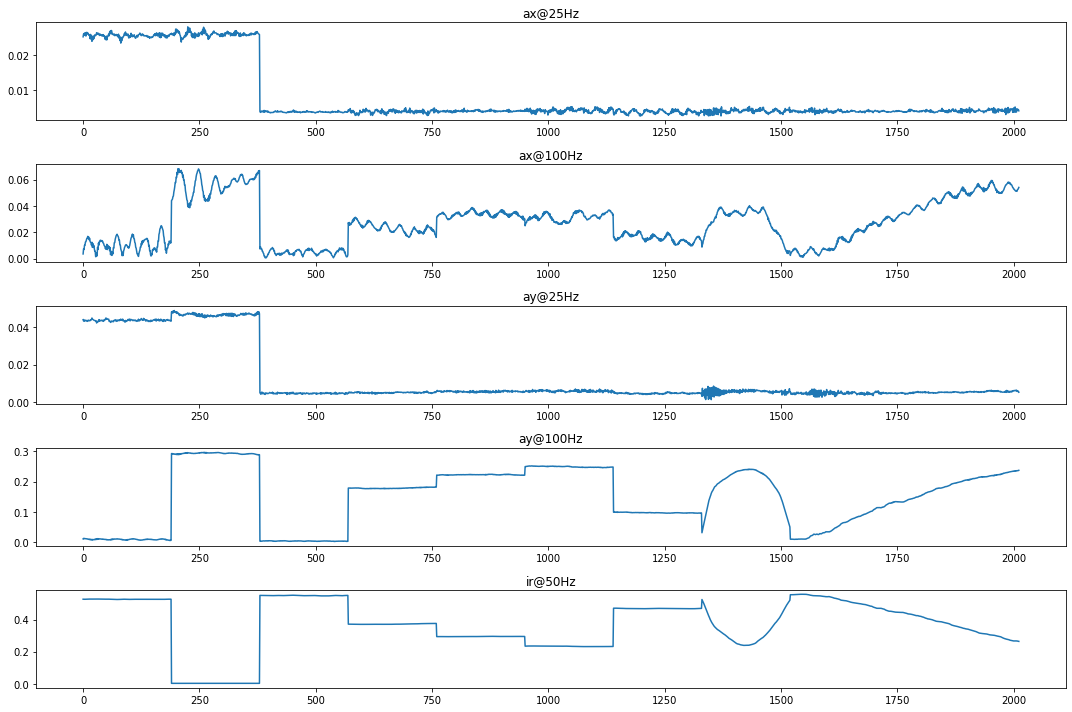

In [3]:
# Parámeetros de enventanado (criterios de agrupamiento de los datos)
N = 1000     # tamaño de la ventana (esto lo elegimos nosotros)
S = 100      # definimos el "salto" entre ventana y ventana 

Fclase = []
F = []
C = []
for k in range(9):
    p = np.array(datos['z'][k]).T
    Q = p.shape[1]
    for j in range(N,Q,S):
        for variable in [0,1,3]:
            v = p[variable,j-N:j]          # definimos la ventana actual con N elementos (p.u. respecto valor nominal)
            V = np.abs(np.fft.fft(v))                # calculamos la fft de la ventana
            f = np.arange(0,fm,fm/N)          # calculamos las frecuencias de cada armónico
            idx1 = np.where((f>20)&(f<30))     # generamos un vector de índices de los elementos que están entre ...
            idx2 = np.where((f>95)&(f<105))    # generamos un vector de índices de los elementos que están entre ...
            idx3 = np.where((f>45)&(f<55))

            C.append(np.sqrt(np.sum(2*V[idx1]**2))/N)
            C.append(np.sqrt(np.sum(2*V[idx2]**2))/N)
            C.append(np.sqrt(np.sum(2*V[idx3]**2))/N)            
        F.append(C)
        Fclase.append(class_labels[k])
        C = []
        

# tras el bucle for, F es una lista de listas
# para poder usar funciones de numpy y matplotlib la convertimos en un array
F = np.array(F)

# Habiendo usado 3 variables y 3 armónicos hay 9 combinaciones. Nos quedamos con las 5 que nos interesan.
F = F[:,[0,1,3,4,8]];
Fclase = np.array(Fclase)

# generamos las etiquetas de las características obtenidas
etiq = []
variables = ['ax','ay','ir']
frecuencias = ['25Hz','100Hz','50Hz']
for i in variables:
    for j in frecuencias:
        etiq.append(i+'@'+j)
etiquetas = [etiq[i] for i in [0,1,3,4,8]]

p = F.T

fig = plt.figure(figsize=(15,10))
for i in range(5):
    subplot(5,1,i+1)
    plt.plot(p[i,:])
    title(etiquetas[i])

tight_layout()

#### Normalización
La normalización es importante para asignar el mismo peso o importancia a todas las variables, independientemente de su rango de variación. *Nota: En casos concretos, no obstante, se puede asignar intencionadamente más peso a unas variables que a otras*.

In [4]:
# Creamos una clase de normalización
minmaxx = MinMaxScaler(feature_range=(0,1))

# Aplicamos método fit para calcular la normalización (hallar máximos y mínimos)
p = minmaxx.fit_transform(p.T).T

### 3. Create and  initialize a SOM model

In [5]:
som = SOM(p,dims=(70,70),labels=etiquetas)
som.pca_init(p)

### 4. Train the SOM model
Entrenamos un SOM de 50x50 neuronas, con 10 épocas y con una vecindad final Nf=1

In [6]:
som.train(p,epochs=50,N_final=5)

Epoch: 0 	 Neigh 70.000000 	 MSE = 0.013678
Epoch: 1 	 Neigh 68.673469 	 MSE = 0.011501
Epoch: 2 	 Neigh 67.346939 	 MSE = 0.005387
Epoch: 3 	 Neigh 66.020408 	 MSE = 0.002019
Epoch: 4 	 Neigh 64.693878 	 MSE = 0.001812
Epoch: 5 	 Neigh 63.367347 	 MSE = 0.001690
Epoch: 6 	 Neigh 62.040816 	 MSE = 0.001677
Epoch: 7 	 Neigh 60.714286 	 MSE = 0.001622
Epoch: 8 	 Neigh 59.387755 	 MSE = 0.001592
Epoch: 9 	 Neigh 58.061224 	 MSE = 0.001547
Epoch: 10 	 Neigh 56.734694 	 MSE = 0.001509
Epoch: 11 	 Neigh 55.408163 	 MSE = 0.001460
Epoch: 12 	 Neigh 54.081633 	 MSE = 0.001424
Epoch: 13 	 Neigh 52.755102 	 MSE = 0.001381
Epoch: 14 	 Neigh 51.428571 	 MSE = 0.001340
Epoch: 15 	 Neigh 50.102041 	 MSE = 0.001296
Epoch: 16 	 Neigh 48.775510 	 MSE = 0.001253
Epoch: 17 	 Neigh 47.448980 	 MSE = 0.001213
Epoch: 18 	 Neigh 46.122449 	 MSE = 0.001178
Epoch: 19 	 Neigh 44.795918 	 MSE = 0.001148
Epoch: 20 	 Neigh 43.469388 	 MSE = 0.001121
Epoch: 21 	 Neigh 42.142857 	 MSE = 0.001092
Epoch: 22 	 Neigh 40

### 5. SOM component planes
El plano de componente "k" muestra el valor representativo de la característica (componente) "k" para cada posición (i,j) del espacio de visualización. Dicho valor representativo es la característica "k" del codebook asociado a la posición (i,j)

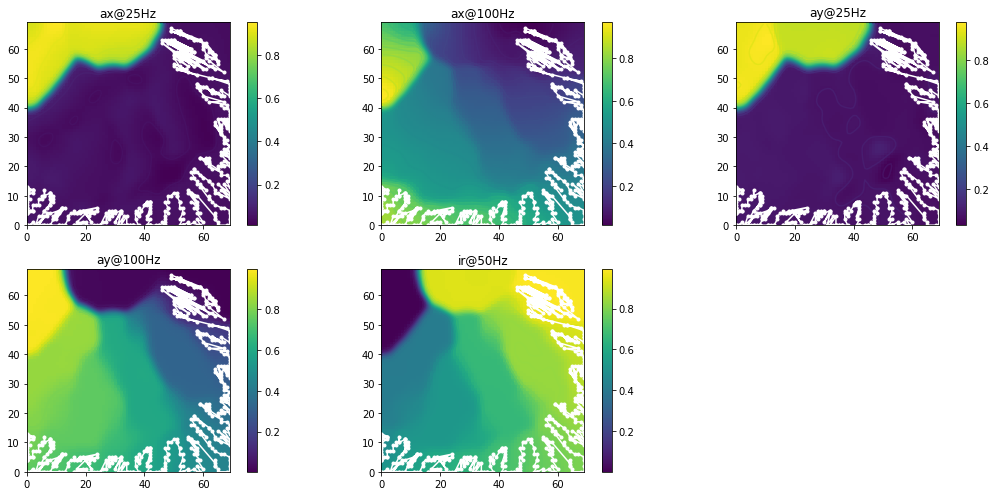

In [7]:
fig = plt.figure(figsize=(15,7))
ax = som.planes();
idx = np.where(Fclase=='Evar2')[0]
pr = som.fproj(p[:,idx])[0]
for i in ax:
    plt.sca(i)
    plt.plot(pr[0,:],pr[1,:],'.-',color='white')

### 6. SOM distance matrix
La matriz de distancias representa las distancias entre codebooks. Esto permite visualizar los agrupamientos de las variables, ya que entre dos agrupamientos las distancias son elevadas (definiendo en el mapa "fronteras"). Dentro de un agrupamiento, las distancias son bajas.

In [8]:
d = som.somdist()

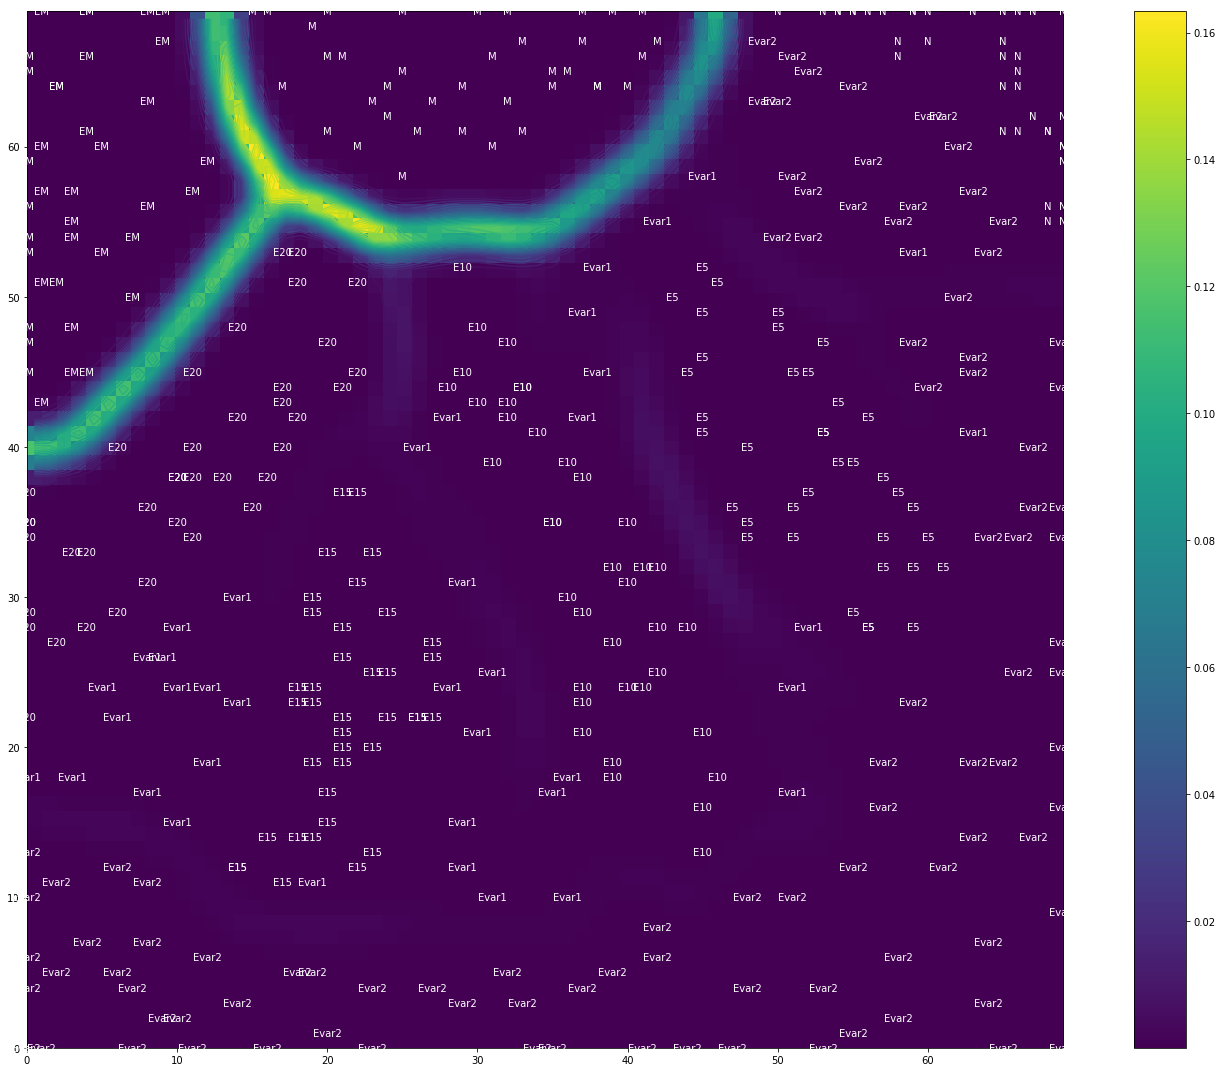

In [9]:
fig = plt.figure(figsize=(20,15))
planes(d,som.gi,som.dims)

pr = som.fproj(p)[0]

for i in arange(0,len(Fclase),5):
    #plot(pr[0,i],pr[1,i],'.',color='w',markersize=20,alpha=0.5)
    plt.text(pr[0,i],pr[1,i],Fclase[i],verticalalignment='center',horizontalalignment='center',color='white')

tight_layout()

### 7. 3D SOM
Mostramos el SOM y los datos en 3D. Dado que hay 5 dimensiones, solo mostramos las 3 primeras. *Nota: usar las tres primeras variables es en realidad un "apaño"; sería más correcto hacer una reducción de la dimensión para ver esto.*

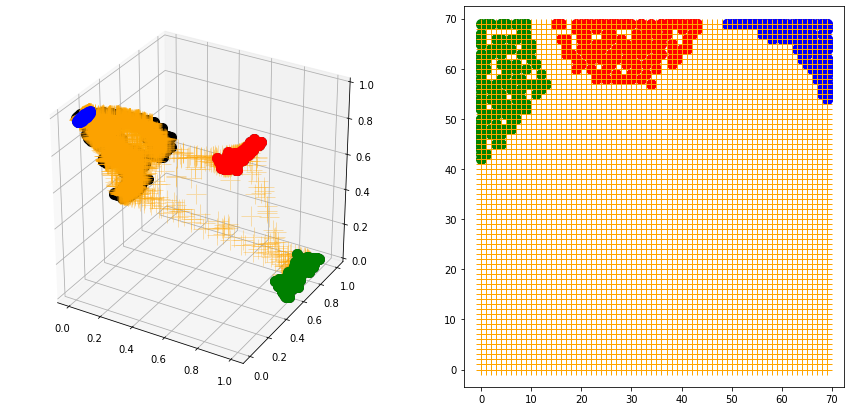

In [10]:
fig = plt.figure(figsize=(15,7))
plt.clf()

# definimos los ejes en los que vamos a dibujar
ax1 = plt.subplot(1,2,1,projection='3d')    # espacio de datos (3D)
ax2 = plt.subplot(1,2,2)                    # espacio de proyecciones (2D)


ax1.plot(p[0,:],p[1,:],p[4,:],'.',c='black',markersize=20)
ax1.plot(som.mi[0,:],som.mi[1,:],som.mi[4,:],'+',c='orange',markersize=20,alpha=0.3)
# ax1.axis('equal')

projections = som.fproj(p)[0]

# proyectamos los datos de la clase de funcionamiento normal "N"
idx = where(Fclase=='N')[0]
ax2.plot(projections[0,idx],projections[1,idx],'.',c='blue',markersize=20)
ax1.plot(p[0,idx],p[1,idx],p[4,idx],'.',c='blue',markersize=20)

# proyectamos los datos de la clase fallo mecánico "M"
idx = where(Fclase=='M')[0]
ax2.plot(projections[0,idx],projections[1,idx],'.',c='red',markersize=20)
ax1.plot(p[0,idx],p[1,idx],p[4,idx],'.',c='red',markersize=20)

# proyectamos los datos de la clase fallo eléctrico y mecánico "EM"
idx = where(Fclase=='EM')[0]
ax2.plot(projections[0,idx],projections[1,idx],'.',c='green',markersize=20)
ax1.plot(p[0,idx],p[1,idx],p[4,idx],'.',c='green',markersize=20)


ax2.plot(som.gi[0,:],som.gi[1,:],'+',c='orange',markersize=10)
ax2.axis('equal');


### 8. SOM residual-based anomaly detection

Comparamos el vector de características del proceso contra las neuronas del SOM entrenado en condiciones consideradas "normales". La diferencia entre ambas la llamamos residuo. Si el residuo es pequeño, la situación se parece a la de entrenamiento (es "normal"). Sin embargo, valores elevados del residuo revelan que el proceso se desvía de las condiciones consideradas "normales".

In [11]:
# creamos un conjunto de datos de entrenamiento, con situaciones consideradas "normales"
idx = where(Fclase=='N')[0]
ptrn = p[:,idx]

Epoch: 0 	 Neigh 50.000000 	 MSE = 0.000031
Epoch: 1 	 Neigh 44.500000 	 MSE = 0.000041
Epoch: 2 	 Neigh 39.000000 	 MSE = 0.000038
Epoch: 3 	 Neigh 33.500000 	 MSE = 0.000035
Epoch: 4 	 Neigh 28.000000 	 MSE = 0.000031
Epoch: 5 	 Neigh 22.500000 	 MSE = 0.000027
Epoch: 6 	 Neigh 17.000000 	 MSE = 0.000023
Epoch: 7 	 Neigh 11.500000 	 MSE = 0.000019
Epoch: 8 	 Neigh 6.000000 	 MSE = 0.000015
Epoch: 9 	 Neigh 0.500000 	 MSE = 0.000009


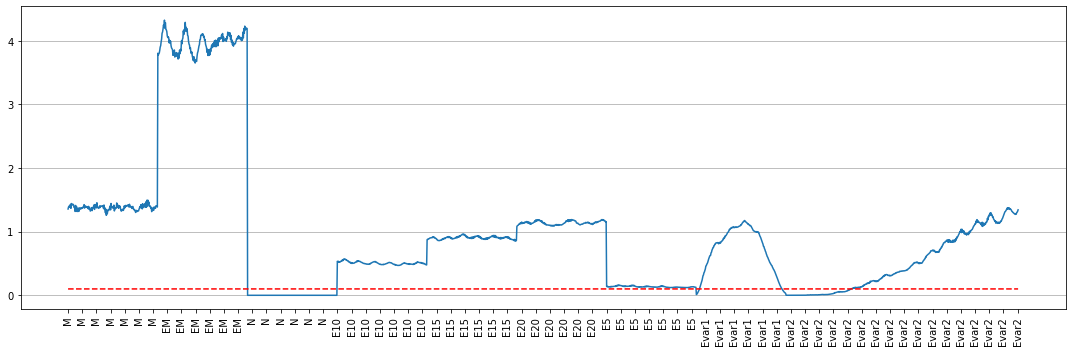

In [12]:
# entrenamos un modelo SOM con los datos de funcionamiento normal
som_normal = SOM(ptrn,dims=(50,50))
som_normal.pca_init(ptrn)
som_normal.train(ptrn,10,N_final=0.5)

# proyectamos todos los estados (normales y de fallo)
# y calculamos los residuos "res"
pr,wc,res,_ = som_normal.fproj(p)

# creamos figura
fig = plt.figure(figsize=(15,5))

# visualizamos la norma (longitud al cuadrado) del vector de residuos
plt.plot(sum(res**2,axis=0))

idx = arange(0,p.shape[1],30)
plt.xticks(idx,Fclase[idx],rotation=90);

plt.grid(True,axis='y');

# definimos "a mano" un umbral y lo representamos. 
# Este umbral lo podríamos definir con procedimientos estadísticos (ej. percentiles)
plt.plot(np.arange(pr.shape[1]),0.1*np.ones((pr.shape[1])),'--',color='red');

plt.tight_layout()

#### Visualización del vector de residuos

El vector de residuos expresa la diferencia entre el vector de datos del proceso $\mathbf x(t)$ y su mejor estimación de acuerdo con el modelo $\mathbf m_{bmu}(t)$ (bmu = *best matching unit*), que representa codebook del SOM más próximo al dato $\mathbf x(t)$.

La norma de la diferencia, $q(t) = \|\mathbf x(t) - \mathbf m_{bmu}(t)\|^2$, denominada en algunos textos *error de cuantificación*, expresa una discrepancia entre la condición o estado actual del proceso y el conjunto de condiciones que contempla el modelo SOM. Si el SOM se entrena en un conjunto de condiciones consideradas "normales", el residuo expresa una situación novedosa que potencialmente puede revelar un estado de fallo.

La diferencia $\mathbf r(t) = \mathbf x(t) - \mathbf m_{bmu}(t)$, denominada *vector de residuos* revela las diferencias componente a componente, lo que, además de reflejar situaciones anómalas, aporta una indicación adicional acerca de cuáles son las variables desviadas.

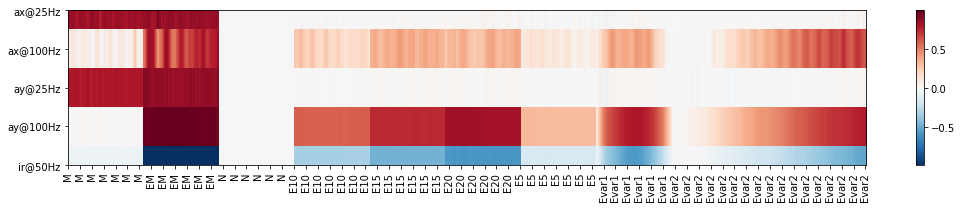

In [13]:
fig = plt.figure(figsize=(15,3))
plt.imshow(res,cmap=plt.cm.RdBu_r)
plt.axis('tight')
plt.colorbar()
idx = np.arange(0,p.shape[1],30)
plt.xticks(idx,Fclase[idx],rotation=90);
plt.yticks(arange(5),etiquetas);
plt.tight_layout()